In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import re
# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, recall_score
# saving
import pickle

In [2]:
df = pd.read_csv('df.csv', index_col=0)

In [3]:
df.head()

,date_reg,adresat,author,content,organization_author
0,09.04.2019,Уразов Р.Н.,Антонова С.В.,возможность использование сетевой издание инфо...,АО Интерфакс
1,09.04.2019,Уразов Р.Н.,Картошкин С.А.,участие совещание вопрос доработка фэо предост...,Министерство просвещения Российской Федерации
2,09.04.2019,Уразов Р.Н.,Цивилев С.Е.,командирование саликов глушко далее участие за...,Администрация Кемеровской области
3,09.04.2019,Иванюк Л.А.,Волков Г.А.,участие чемпионат профессиональный мастерство ...,Министерство транспорта Российской Федерации
4,09.04.2019,Уразов Р.Н.,Атанов И.В.,участие церемония открытие вузовский чемпионат...,Ставропольский государственный аграрный унив...


In [4]:
df['date_reg'] = pd.to_datetime(df['date_reg'])

In [5]:
df['date_reg'] = df['date_reg'].dt.to_period('M')

---

# 3.1 Обучение

## На данном этапе на необходимо:
- Провести обучение выбранной модели на обучающей выборке, сформированной в предыдущей сессии
- Протестировать работу обученной модели на тестовой выборке
- Определить показатели точности работы выбранной модели и сравнить их сравните с остальными рассматриваемыми моделями.

## Для оценки классификации мы возьмем следущие метрики:
1. `accuracy_score` - классификационная оценка точности
2. `f1_score` - среднее гармоническое между точностью и ответом
3. `recall_score` - это отношение количества истинных положительных результатов и количества ложных отрицательных результатов

Для начала объединим в отдельную колонку данные с датой, текстом и организаций для последущего разделения на тестовую и обучающую выборки. В предыдущей сессии мы использовали только содержание документа, поэтому посмотрим, улучшатся ли показатели

In [6]:
tmp = []
for i in range(len(df)):
    tmp.append(str(df.iloc[i]['date_reg'])  + ' ' + df.iloc[i]['content'] + ' ' + df.iloc[i]['organization_author'])

Назовем новую колонку total, именно она и будет далее использована при разбиении на выборки

In [7]:
df['total'] = tmp

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df['total'], df['adresat'], test_size=0.33)

Обучаем наши данные (работа данного метода была описана в предыдущей сессии)

In [62]:
models = [
    KNeighborsClassifier(),
    RandomForestClassifier(),
    LogisticRegression()
]
for model in models:
    print(str(model))
    pipe = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', model)])
    text_clf = pipe.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    print('\taccuracy_score', accuracy_score(pred, y_test))
    print('\tf1_score', f1_score(pred, y_test, average='weighted'))
    print('\trecall_score', recall_score(pred, y_test, average='macro'))

KNeighborsClassifier()
	accuracy_score 0.6573170731707317
	f1_score 0.6846690121730787
	recall_score 0.16197260768395785
RandomForestClassifier()
	accuracy_score 0.7060975609756097
	f1_score 0.7422462599457889
	recall_score 0.20674706172432222
LogisticRegression()
	accuracy_score 0.6695121951219513
	f1_score 0.7252424578727685
	recall_score 0.11187463406401552


Как мы видим, показатели стали незначительно, но лучше, чем в предыдущей сессии. Лучше всего себя показала модель RandomForestClassifier()

# 3.2 Feature Engineering

Сейчас нам необходимо улучшить наши показатели путем добавления новых атрибутов или же любым другим методом, который поможет добиться более точной работы модели

## Добавление атрибута с помощью тематического моделирования содержания документа

- Тематическое моделирование — это способ семантического анализа коллекции текстовых документов. Тематическая модель позволяет для каждого документа найти темы, которые его описывают, и кроме того показывает, какие слова характеризуют ту или иную тему

Сделаем это с помощью неотрицательная матричная факторизации, то есть NMF

In [13]:
#векторизируем наш текст
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
doc_term_matrix = tfidf_vect.fit_transform(df['content'].values.astype('U'))
from sklearn.decomposition import NMF

nmf = NMF(n_components=18, random_state=0)
nmf.fit(doc_term_matrix )

#присваиваем каждой теме номер, который относится к специализации адресата и добавляем его в столбец
topic_values = nmf.transform(doc_term_matrix)
df['topic'] = topic_values.argmax(axis=1)

## Подбор гипермараметров для улучшения результатов обученяи модели

Добитьтся более точной работы модели можно также с помощью побора гиперпараметров, используя GridSearchCV. Он находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров

Для начала преобразуем данные для более корректного и точного определения гиперпараметров

In [73]:
#векторизируем наши данные
vect = CountVectorizer().fit(X_train)
X_train = vect.transform(X_train)
#нормализация
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)

Будем использовать GridSearchCV для каждой модели и покажем следущие результаты:
- `best score` - наилучший результ работы модели во время перекрестной проверки (будет использована метрика 'accuracy')
- `best model` - параметры модели, которая и показала наилучший результат при своей работе

### KNeighborsClassifier

In [64]:
from sklearn.model_selection import GridSearchCV
model = KNeighborsClassifier()
param_search = { 
    'n_neighbors': [5,10,15,20],
    'weights': ['uniform', 'distance'],
    'metric' : ['minkowski','euclidean','manhattan']
}


gsearch = GridSearchCV(estimator=model,  param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print('best score: ', best_score)
print('best model: ', best_model)

best score:  0.6789880105669579
best model:  KNeighborsClassifier(n_neighbors=10, weights='distance')


### RandomForestClassifier

In [74]:
model = RandomForestClassifier()
param_search = { 
    'n_estimators': [20, 50, 100],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth' : [i for i in range(5,50)]
}

gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print('best score: ', best_score)
print('best model: ', best_model)

best score:  0.6904070988281514
best model:  RandomForestClassifier(max_depth=46)


при подборе гиперпараметров данной модели, показатели значительно ухудшились, поэтому в конечном сравнении работы разных алгоритмов мы не будем использовать эти гиперпараметры

### LogisticRegression

In [66]:
model = LogisticRegression()
param_search = { 
    'penalty': ['l1', 'l2', 'lasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

gsearch = GridSearchCV(estimator=model, cv=5, param_grid=param_search, scoring = 'accuracy')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print('best score: ', best_score)
print('best model: ', best_model)

best score:  0.7024380771749194
best model:  LogisticRegression(penalty='none', solver='saga')


У KNeighborsClassifier и LogisticRegression же результаты работы стали точнее, поэтому их гиперпараметры мы далее используем

##### Снова разделяем наши данные на выборки и обучаем с полученными гиперпараметрами

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['total'], df['adresat'], test_size=0.33)

In [12]:
models = [
    KNeighborsClassifier(n_neighbors=10, weights='distance'),
    RandomForestClassifier(),
    LogisticRegression(penalty='none', solver='saga')
]
res =pd.DataFrame()
for model in models:
    tmp={}
    print(str(model))
    tmp["model"] = str(model)
    # pipeline
    pipe = Pipeline([("vect", CountVectorizer()),("tfidf", TfidfTransformer()),("clf", model)])
    # classification
    text_clf = pipe.fit(X_train, y_train)
    pred = text_clf.predict(X_test)
    # metrics
    print("\taccuracy_score", accuracy_score(pred, y_test))
    print("\tf1_score", f1_score(pred, y_test, average="weighted"))
    print("\trecall_score", recall_score(pred, y_test, average="macro"))
    tmp["accuracy_score"] = accuracy_score(pred, y_test)
    tmp["f1_score"] = f1_score(pred, y_test, average="weighted")
    tmp["recall_score"] = recall_score(pred, y_test, average="macro")
    res = res.append(tmp, ignore_index=True)
    print("<================>")

KNeighborsClassifier(n_neighbors=10, weights='distance')
	accuracy_score 0.6957317073170731
	f1_score 0.7269498588863073
	recall_score 0.18408696225288607
<================>
RandomForestClassifier()
	accuracy_score 0.7201219512195122
	f1_score 0.7566189046965935
	recall_score 0.21486738687088622
<================>
LogisticRegression(penalty='none', solver='saga')
	accuracy_score 0.7012195121951219
	f1_score 0.7224726903029121
	recall_score 0.19673892523782865
<================>


In [17]:
res.index = res.model

In [18]:
res = res.drop(["model"], axis=1)

<AxesSubplot:xlabel='model'>

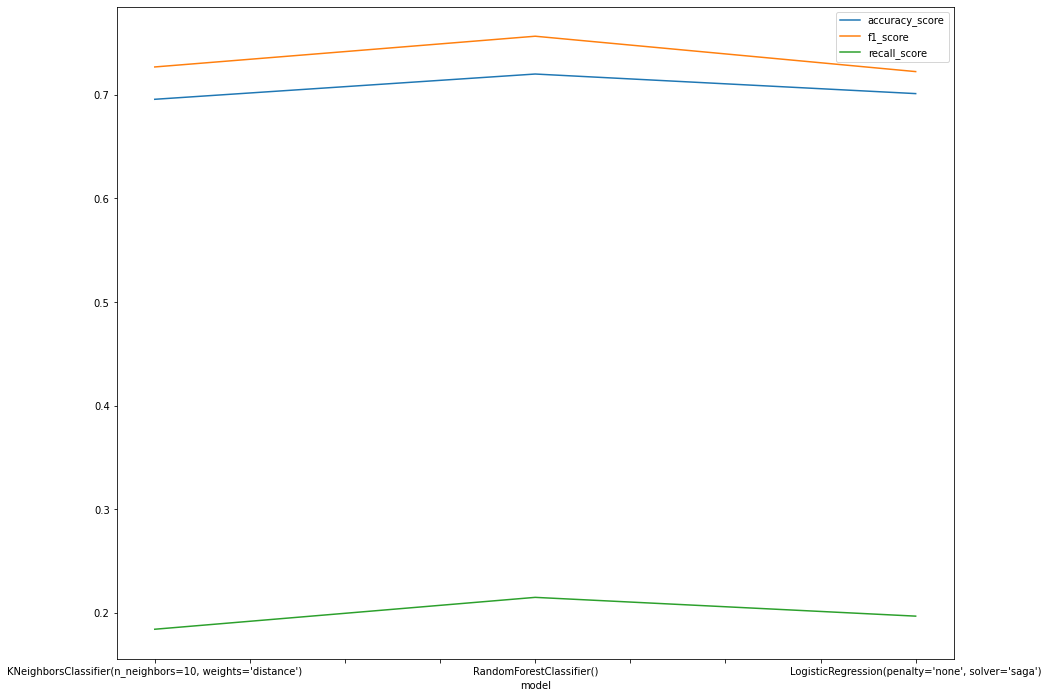

In [19]:
res.plot(figsize=(15,12))

Видим, что модель RandomForestClassifier справилась лучше остальных, поэтому далее ее мы и будем использовать

In [21]:
# model fitting
model = Pipeline([("vect", CountVectorizer()),
                  ("tfidf", TfidfTransformer()),
                  ("clf", RandomForestClassifier())])
text_clf = pipe.fit(X_train, y_train)

# Saving as pkl file
pkl_filename = "modell.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(text_clf, file)

In [8]:
df.to_csv('df.csv')